This assignment makes use of MCMC and bayesian inference methods to simulate multiple problems from ML domain (regression and island). 

The code is written in such a way that the user can define the priors and likelihood along with multiple other parameters available in ``pymc3`` library. That way a user can play around with the parameters and assess the different results based on different selection of the priors, likelihood and the parameters.

Once the problem is simulated and the posterior is estimated, the posterior is then used to create more data (similar to the original one) by using pymc3 predictive capabilities. If the generated data and its mean from the estimated posterior is close to the distibution and mean of the original data, we can safely infer that the estimated posterior is in fact correct and is a good measure of the original distibution of the data. If the output graphs of original data and the data generated via estimated posterior are not close enough, then the user can try different priors and likelihood or different combinations of pymc3 parameters.

### Libraries

In [1]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz
import seaborn as sns
from sklearn.linear_model import LinearRegression

%matplotlib inline
%precision 4
plt.style.use('ggplot')

np.random.seed(1234)
import pymc3 as pm
import scipy.stats as stats

import logging
_logger = logging.getLogger("theano.gof.compilelock")
_logger.setLevel(logging.ERROR)

### Functions

In [11]:
# observed data
# Creates data for regression problem

def datagen_lr(n, _a, _b):
  x = np.linspace(0, 1, n)
  y = _a*x + _b + np.random.randn(n)
  og_y_mean = y.mean()
  return x,y,og_y_mean

# Applies different EDA methods and generate graphs
def eda(x,y):

  print("\n\n")
  plt.scatter (x,y)
  plt.title("Generated Data")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.show()

  df = pd.DataFrame()
  df['x'] = x
  df['y'] = y
  plt.figure(figsize=(16, 6))
  # define the mask to set the values in the upper triangle to True
  mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
  heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
  heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
  plt.show()

# Regression function that uses pymc3 methods to simulate the problem. 
def lr():

  # taking user inputs for priors
  prior_parameter = int(input("\n\n-------------- PRIOR DISTIBUTIONS FOR LINEAR REGRESSION PARAMETERS -----------------\n\nPress 1: Normal (Recommended)\nPress 2: Uniform\nPress 3: Gamma\n"))
  
  if prior_parameter == 1:
    mu_a = int(input("\nEnter the mu for Normal Distibution from which y-intercept will be sampled (eg: mu = 0)\n"))
    mu_b = int(input("\nEnter the mu for Normal Distibution from which slope will be sampled (eg: mu = 0)\n"))
    sd_a = int(input("\nEnter the standard deviation for Normal Distribution from which y-intercept is to be sampled (eg: sd = 7)\n"))
    sd_b = int(input("\nEnter the standard deviation for Normal Distribution from which slope is to be sampled (eg: sd = 10)\n"))

  if prior_parameter == 2:
    bounds_a = [int(input("\nEnter Lower and Upper bounds of Uniform Distribution from which y-intercept is to be sampled (eg: 0 (Lower Bound)->ENTER->10 (Upper Bound)->ENTER)\n")) for i in range(0,2)]
    #if bounds_a[0] == 0:
     # bounds_a[0] = 1

    bounds_b = [int(input("\nEnter Lower and Upper bounds of Uniform Distribution from which slope is to be sampled (eg: 0 (Lower Bound)->ENTER->10 (Upper Bound)->ENTER)\n")) for i in range(0,2)]
    #if bounds_b[0] == 0:
     # bounds_b[0] = 1
  
  if prior_parameter == 3:
    alpha_a = int(input("\nEnter the alpha value for Gamma Distibution from which y-intercept will be sampled (eg: alpha = 7)\n"))
    alpha_b = int(input("\nEnter the alpha value for Gamma Distibution from which slope will be sampled (eg: alpha = 7)\n"))
    beta_a = int(input("\nEnter the beta value for Gamma from which y-intercept is to be sampled (eg: beta = 1)\n"))
    beta_b = int(input("\nEnter the beta value deviation for Gamma from which slope is to be sampled (eg: beta = 1)\n"))

  prior_error = int(input("\n\n--------------- PRIOR DISTRIBUTIONS FOR SAMPLING ERROR ----------------------\n\nPress 1: Normal\n Press 2: Uniform\n Press 3: Half-Normal (Recommended)\n Press 4: Exponential\n Press 5: Gamma\n")) 

  if prior_error == 1:
    mu_e = int(input("\nEnter the mu for Normal Distibution from which error will be sampled (eg: mu = 0)\n"))
    sd_e = int(input("\nEnter the standard deviation for Normal Distribution from which error is to be sampled (eg: sd = 1)\n"))

  if prior_error == 2:
    bounds_e = [int(input("\nEnter Lower and Upper bounds of Uniform Distribution from which error is to be sampled (eg: 0 (Lower Bound)->ENTER->1 (Upper Bound)->ENTER)\n")) for i in range(0,2)]
    #if bounds_e[0] == 0:
     # bounds_e[0] = 1

  if prior_error == 3:
    sd_e = int(input("\nEnter the standard deviation for Half-Normal Distribution from which error is to be sampled (eg: sd = 1)\n"))

  if prior_error == 4:
    sd_e = int(input("\nEnter the standard deviation for Exponential Distribution from which error is to be sampled (eg: sd = 1)\n"))

  if prior_error == 5:
    alpha_e = int(input("\nEnter the alpha for Gamma Distibution from which error will be sampled (eg: alpha = 1)\n"))
    beta_e = int(input("\nEnter the beta for Gamma Distribution from which error is to be sampled (eg: beta = 0.5)\n"))  

  # Taking user inputs for likelihoods
  likelihood_= int(input("\n\n-------------- LIKELIHOOD DISTRIBUTIONS FOR LINEAR REGRESSION -----------------\n\nPress 1: Normal (Recommended)\nPress 2: Uniform\nPress 3: Gamma\n"))

  if likelihood_ == 2:
    bounds_l = [int(input("\nEnter Lower and Upper bounds of Uniform Distribution from which Likelihood is to be sampled (eg: 0 (Lower Bound)->ENTER->10 (Upper Bound)->ENTER)\n")) for i in range(0,2)]
    #if bounds_a[0] == 0:
     # bounds_a[0] = 1

  # Taking user input for MCMC sampling functions
  step_func = int(input("\n\n-------------------- MCMC SAMPLING FUNCTIONS -----------------------------\n\nPress 1: NUTS\nPress 2: SLICE\nPress 3: Metropolis\nPress 4: Hamiltonian MC\n\n")) 

  # Taking user input for LR parameters
  print("\n\n------------------------ PARAMETER INITIALIZATION --------------------------\n\n")
  _a = int(input("\nEnter the y-intercept value (eg: 6)\n"))
  _b = int(input("\nEnter a value for slope (eg: 2)\n"))

  # Taking user inputs for different pymc3 parameters (number of samples at each MCM node, number of tuning samples, number of chains etc)
  niter = int(input("\nEnter the number of MCMC nodes (eg: 10000)\n"))
  n = int(input("\nEnter the sampling number at each MCMC node (eg: 100)\n"))
  tuning_samples = int(input("\nEnter the number of tuning samples (Recommended: 1000)\n"))
  chains_ = int(input("\nEnter the number of MCMC Chains (eg: 2)\n"))
   
  # Calling functions
  x,y,og_y_mean = datagen_lr(n, _a, _b)
  eda(x,y)

  # Creating MCMC model
  with pm.Model() as model:

      if prior_parameter == 1:
        a = pm.Normal('a', mu=mu_a, sd=sd_a)
        b = pm.Normal('b', mu=mu_b, sd=sd_b)
      if prior_parameter == 2:
        a = pm.Uniform('a', lower = bounds_a[0], upper = bounds_a[1])
        b = pm.Uniform('b', lower = bounds_b[0], upper = bounds_b[1])
      if prior_parameter == 3:
        a = pm.Gamma('a', alpha = alpha_a, beta = beta_a)
        b = pm.Gamma('b', alpha = alpha_b, beta = beta_b)       

      if prior_error == 1:
        sigma = pm.Normal('sigma', mu = mu_e, sd = sd_e)
      if prior_error == 2:
        sigma = pm.Uniform('sigma', lower = bounds_e[0], upper = bounds_e[1])
      if prior_error == 3:
        sigma = pm.HalfNormal('sigma', sd=sd_e)
      if prior_error == 4:
        sigma = pm.Exponential('sigma', lam = sd_e)
      if prior_error == 5:
        sigma = pm.Gamma('sigma', alpha = alpha_e, beta = beta_e)

      y_est = a*x + b # simple auxiliary variables

      if likelihood_ == 1:
        likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)
      if likelihood_ == 2:
        likelihood = pm.Uniform('y', lower = bounds_l[0], upper = bounds_l[1])
      if likelihood_ == 3:
        likelihood = pm.Gamma ('y', mu=y_est, sd=sigma, observed=y)
    
      # inference
      #start = pm.find_MAP()
      if step_func == 1:
        step = pm.NUTS() # Hamiltonian MCMC with No U-Turn Sampler
      if step_func == 2:
        step = pm.Slice()
      if step_func == 3:
        step = pm.Metropolis()
      if step_func == 4:
        step = pm.HamiltonianMC()

      trace = pm.sample(draws = niter, step = step, random_seed=123, progressbar=True, return_inferencedata=True, tune = tuning_samples, chains = chains_)
      #trace = pm.sample(niter, step, start, tune=1000, random_seed=124, progressbar=True)
      arviz.plot_trace(trace)
      arviz.plot_posterior(trace)
      print(pm.summary(trace))
      map_estimate = pm.find_MAP(model=model)
      print(map_estimate)

 
      # Display the total number and percentage of divergent chains
      diverging = np.array(trace.sample_stats.diverging[0])
      d = diverging.nonzero()[0].size
      if d == 0:  
        print('\n\nNumber of Divergent Chains: {}'.format(d))
        diverging_pct = diverging.nonzero()[0].size / len(trace) * 100
        print('\nPercentage of Divergent Chains: {:.1f}'.format(diverging_pct))   
        arviz.plot_pair(trace, var_names=['a','b'],  kind='kde', group="posterior",   divergences=True,  colorbar=True, divergences_kwargs={'color': 'C2'})
      if d>0:
        print('\n\nNumber of Divergent Chains are {}'.format(d))
        print("\nTry using other prior and likelihood distributions with sound parameter values")
        diverging_pct = diverging.nonzero()[0].size / len(trace) * 100
        print('\nPercentage of Divergent Chains: {:.1f}'.format(diverging_pct))   
        arviz.plot_pair(trace, var_names=['a','b'],  kind='kde', group="posterior",   divergences=True,  colorbar=True, divergences_kwargs={'color': 'C2'})

  return model, y, og_y_mean, y_est, trace

# Function to create additional data based on the posterior estimated in the above function
def posterior_(model, y, og_y_mean, y_est, trace):
  with model:
    dic = pm.sampling.fast_sample_posterior_predictive(trace, var_names = ('a','b','y'), model= model)
    pred_mean = dic['y'].mean()
    print("\n\nBy using the posterior distribtution of the problem new data is generated")
    print("\nThe original data mean is {0} and newly generated data mean by predicted posterior is {1}".format(og_y_mean,pred_mean))
    if (abs(pred_mean-og_y_mean) <= 0.5):
      print("\n The newly generated data (from predicted posterior distribution) follows the pdf of the original data\n")
    if (abs(pred_mean-og_y_mean) > 0.5 and abs(pred_mean-og_y_mean) < 2):
      print("\n The newly generated data (from predicted posterior distribution) somewhat follows the pdf of original data. However it can be improved")
    if (abs(pred_mean-og_y_mean) > 2):
      print("\nTry using different prior and likelihood combinations with sound parameter values")
  y_ = dic['y'][-1]
  return (y, y_)


# Creating the data for island problem
def make_islands(n, low=10, high=101):
    """
    Generate islands with random population between low and high.
    Args:
        n: Number of islands in chain
        low:  minimum population of an island
        high: maximum population of an island

    Return:
        A vector of length n+2.  The first and last entries are 0.  The entry
        in position i represents the population of island i, which is between
        low and high
    """
    # generate the populations are random integers
    islands = np.random.randint(low, high, n+2)
    # first and last islands have 0 population
    islands[0] = 0
    islands[-1] = 0
    return islands

def hop(start,islands, niter):
    """
    This function simulates the politician travelling between islands

    Args:
        islands: vector of island populations, created by make_islands function
        start:  number of island on which the politician starts his canvasing
        niter:  number of interations (days the politician spends canvasing)

    Return:
        The vector samples, in which position i indicates the number of the island
        on which the position is located on day i
    """
    # starting island number
    
    pos = start
    # starting island population
    pop = islands[pos]
    # create empty vector to hold island indices
    samples = np.zeros(niter+1, dtype='int')
    # first day is spent on island with index pos, defined above
    samples[0] = pos
    # loop through each day of travel
    for i in range(niter):
        # generate sample from proposal distribution
        # -1 represents a step to a lower number island
        # 1 represents a step to a higher number island
        k = np.random.choice([-1, 1], 1)[0]
        # next proposed island
        next_pos = pos + k
        # evaluate unnormalized target distribution at proposed position
        # get population of next proposed island
        next_pop = islands[next_pos]
        # calculate acceptance probability
        # this is ratio populations
        # probability cannot be greater than 1, so we take minimum
        p = min(1, next_pop/pop)
        # use uniform random to decide accept/reject proposal
        if np.random.random() < p:
            # if we accept, update position and population
            pos = next_pos
            pop = next_pop
        # store position at time i+1
        samples[i+1] = pos
    island_pop = islands[1:len(islands)-1]
    stay = np.bincount(samples)[1:]
    return samples, stay, island_pop

def plot_islands(islands, stay, island_pop):
    # plot the true proportions of the total population on each island
    data = islands[1:-1]
    # normalize by total population
    data = data/data.sum()
    # make a barplot
    sns.barplot(x=np.arange(1, len(data)+1), y=data)
    plt.plot(island_pop, stay)
    plt.show()

# Simulating the problem via MCMC methods
def isl():

  niter= int(input("\n\nEnter the total number of canvasing days (eg: 1000)\n"))
  n = int(input("\nEnter the number of islands (eg: 10)\n"))
  low = int(input("\nEnter the lowest population for an island (eg: 100)\n"))
  high = int(input("\nEnter the highest population for an island (eg: 3000)\n"))
  start = 1
  n_sample = int(input("\nEnter the number of samples at each step (eg: 10000)\n"))
  n_tuning = int(input("\nEnter the number of tuning samples (eg: 1000)\n"))
  # observed data
  islands = make_islands(n, low,high)
  samples, stay, island_pop = hop(start,islands, niter)

  y = stay
  x = island_pop
  x_norm = np.log(x)
  y_norm = np.log(y)
  x_ = x.reshape(-1,1)
  model = LinearRegression().fit(x_, y)
  #r_sq = model.score(x_norm_, y_norm)
  intercept = model.intercept_
  slope = model.coef_[0]

  _a = slope
  _b = intercept


  with pm.Model() as model:
      a = pm.Normal('a', 0,5)
      b = pm.Gamma('b', 4, 0.2)
      sigma = pm.HalfNormal('sigma', 1)

      y_est = a*x + b # simple auxiliary variables
    
      likelihood = pm.Gamma('y', alpha = y_est, beta = sigma, observed=y)
    
      # inference
      #start = pm.find_MAP()
      step = pm.NUTS(target_accept = 0.95) # Hamiltonian MCMC with No U-Turn Sampler
      trace = pm.sample(n_sample, step = step, progressbar=True, chains = 2, tune = n_tuning,return_inferencedata=True)
      arviz.plot_trace(trace);
      print(pm.summary(trace))
      map_estimate = pm.find_MAP(model=model)
      print(map_estimate)
      arviz.plot_posterior(trace)


      dic = pm.sampling.fast_sample_posterior_predictive(trace, var_names = ('a','b','y'), model= model)
      y_pred = dic['y'][-1]
      y_pred_mean = dic['y'][-1].mean()
      y_mean = y.mean()
      print("\n\nBy using the posterior distribtution of the problem new data is generated")
      print("\nThe original data mean is {0} and newly generated data mean by predicted posterior is {1}".format(y_mean,y_pred_mean))
      if (abs(y_pred_mean-y_mean) <= 0.5):
        print("\n The newly generated data (from predicted posterior distribution) follows the pdf of the original data\n")
      if (abs(y_pred_mean-y_mean) > 0.5 and abs(y_pred_mean-y_mean) < 2):
        print("\n The newly generated data (from predicted posterior distribution) somewhat follows the pdf of original data. However it can be improved")
      if (abs(y_pred_mean-y_mean) > 2):
        print("\nTry using different prior and likelihood combinations with sound parameter values") 

      plt.scatter(np.linspace(1,n,n), y_pred)
      plt.title("Distribution of Stay (Predicted)")
      plt.show()

      plt.scatter(np.linspace(1,n,n), y)
      plt.title("Distribution of Stay (Actual)")
      plt.show()
  return y_pred, n



def main():
  while (1):

    d_input = int(input("\n\n----------------------------- PROBLEM DOMAINS -------------------------\n\nPress 1: Linear Regression via Bayesian Inference\n Press 2: Island Problem via Bayesian Inference\nPress 0: Exit\n\n"))
    if d_input == 1:
      model,y,og_y_mean, y_est, trace = lr()
      print("\n\n\n")
      y, y_ = posterior_(model,y, og_y_mean,y_est, trace)
      print("\n\n\n")

      plt.figure(figsize=(100,100))
      plt.subplot(10,10,1)
      plt.plot(y, label = "Original Data", color = 'b')
      plt.plot(y_, label = "Newly Generated Data (from predicted posterior)", color = 'r')
      plt.legend()
      plt.show()

    if d_input == 2:
      y_pred, n = isl()
      #plt.scatter(np.linspace(1,n,n), y_pred)
      #plt.title("Distribution of Stay (Actual)")
      #plt.show()

    if d_input == 0:
      break




### Main



----------------------------- PROBLEM DOMAINS -------------------------

Press 1: Linear Regression via Bayesian Inference
 Press 2: Island Problem via Bayesian Inference
Press 0: Exit

1


-------------- PRIOR DISTIBUTIONS FOR LINEAR REGRESSION PARAMETERS -----------------

Press 1: Normal (Recommended)
Press 2: Uniform
Press 3: Gamma
1

Enter the mu for Normal Distibution from which y-intercept will be sampled (eg: mu = 0)
0

Enter the mu for Normal Distibution from which slope will be sampled (eg: mu = 0)
0

Enter the standard deviation for Normal Distribution from which y-intercept is to be sampled (eg: sd = 7)
7

Enter the standard deviation for Normal Distribution from which slope is to be sampled (eg: sd = 10)
10


--------------- PRIOR DISTRIBUTIONS FOR SAMPLING ERROR ----------------------

Press 1: Normal
 Press 2: Uniform
 Press 3: Half-Normal (Recommended)
 Press 4: Exponential
 Press 5: Gamma
3

Enter the standard deviation for Half-Normal Distribution from which error i

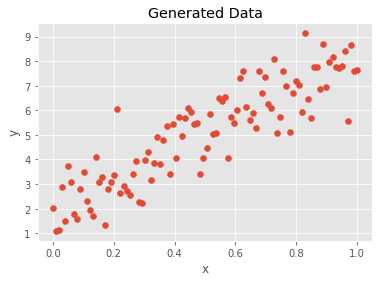

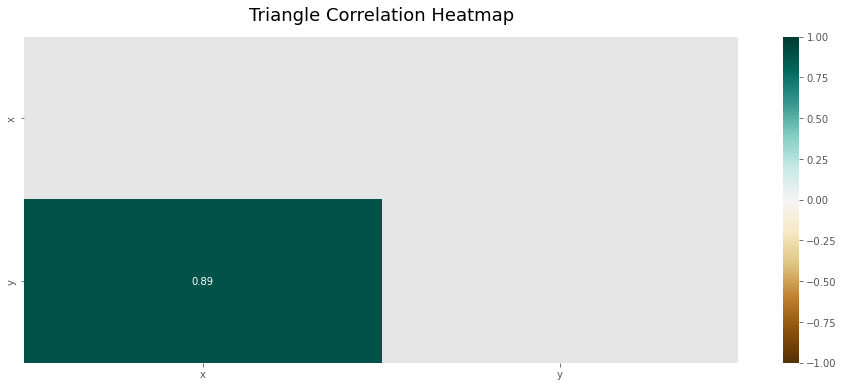

Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.879055252205983, but should be close to 0.8. Try to increase the number of tuning steps.


        mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
a      6.248  0.335   5.607    6.872  ...    0.002    8982.0    9275.0    1.0
b      1.975  0.195   1.604    2.333  ...    0.001    8883.0    9505.0    1.0
sigma  0.953  0.070   0.834    1.092  ...    0.000   10421.0   10098.0    1.0

[3 rows x 9 columns]



{'a': array(6.2473), 'b': array(1.975), 'sigma_log__': array(-0.0713), 'sigma': array(0.9312)}


Number of Divergent Chains: 0

Percentage of Divergent Chains: 0.0






By using the posterior distribtution of the problem new data is generated

The original data mean is 5.098801983937841 and newly generated data mean by predicted posterior is 5.098902381049388

 The newly generated data (from predicted posterior distribution) follows the pdf of the original data







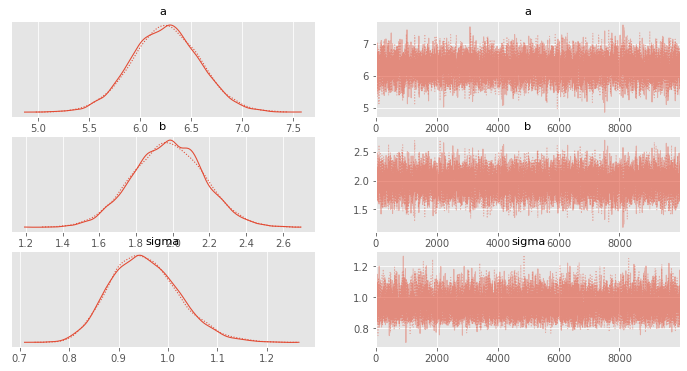

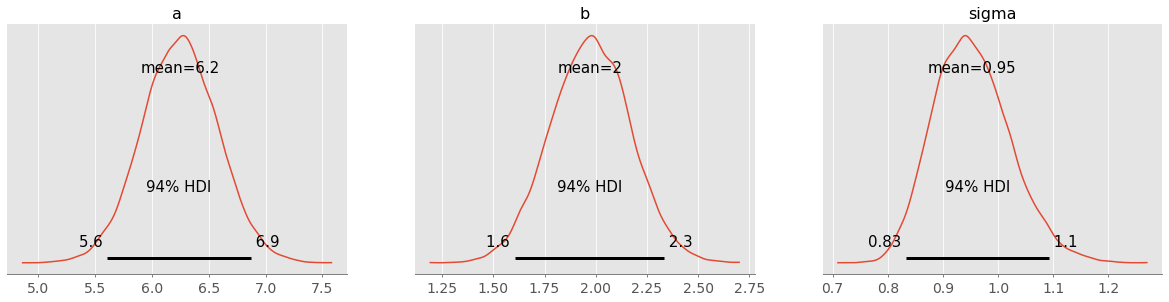

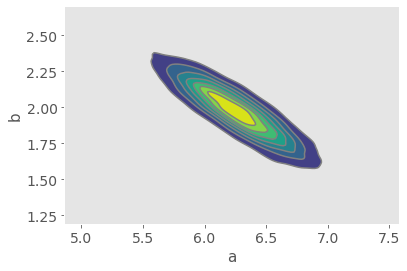

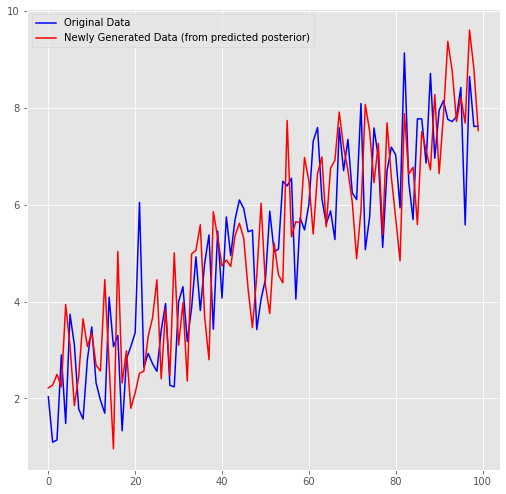



----------------------------- PROBLEM DOMAINS -------------------------

Press 1: Linear Regression via Bayesian Inference
 Press 2: Island Problem via Bayesian Inference
Press 0: Exit

2


Enter the total number of canvasing days (eg: 1000)
1000

Enter the number of islands (eg: 10)
10

Enter the lowest population for an island (eg: 100)
100

Enter the highest population for an island (eg: 3000)
2000

Enter the number of samples at each step (eg: 10000)
10000

Enter the number of tuning samples (eg: 1000)
1000


Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 94 seconds.


        mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
a      0.051  0.019   0.018    0.087  ...    0.000    5227.0    5816.0    1.0
b      4.188  1.730   1.227    7.421  ...    0.015    6234.0    6459.0    1.0
sigma  0.480  0.167   0.184    0.789  ...    0.002    5094.0    5506.0    1.0

[3 rows x 9 columns]



{'a': array(-0.0977), 'b_log__': array(1.9408), 'sigma_log__': array(-2.1754), 'b': array(6.9642), 'sigma': array(0.1136)}


By using the posterior distribtution of the problem new data is generated

The original data mean is 100.1 and newly generated data mean by predicted posterior is 91.48961344351542

Try using different prior and likelihood combinations with sound parameter values


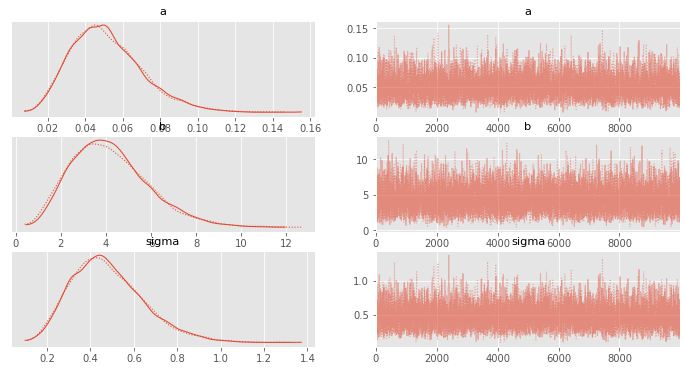

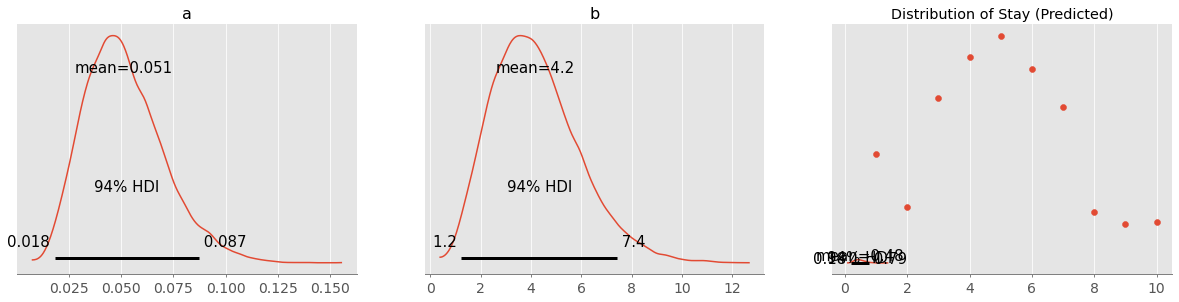

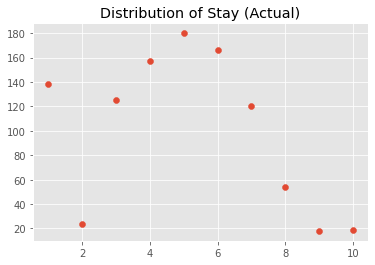



----------------------------- PROBLEM DOMAINS -------------------------

Press 1: Linear Regression via Bayesian Inference
 Press 2: Island Problem via Bayesian Inference
Press 0: Exit

0


In [13]:
main()

### Outputs

The output of simulated regression problem and island problem are shown in above.

The linear regression outputs via MCMC methods (with recommended parameters, priors and likelihood) shows that the estimated posterior is a good measure of actual distribution of the problem. For the purpose of the test run, the values of regression parameters were taken as 6 and 2 (as seen from the output cell above). The MCMC simulation estimated the parameter values as 6.2 and 1.9 which seems pretty close to the actual. The additional data generated via estimated posterior gave a mean of 5.0989 while the actual data mean is 5.0988 which is again quite close to each other. The variables are uncorrelated as shown above with eliptical graph. IF the graph had shown a straight line then it would pose a problem for MCMC algorithm as the variables would be highly correlated. Moreover, the graph of original and estimated data are almost similar (as shown above) with a few discrepancies but that is understandable because of the nature of the simulation. 

The island problem is simulated and shown in the output cell above as well. For the test run of the problem, the number of islands were choosen to be 10 with minimum population of 100 and maximum of 2000. Along with that the total number of canvasing days were taken as 1000. (All of these parameters can be changed by user while running the code).

The objective of the problem is to determine the distribution of the stay of politician on each of the island. The problem is simulated with different priors and likelihood and the results are shown above. 

It can be seen from the graph of actual distribution and estimated distribution (based on the posterior) that the estimated posterior was able to map the orignal distribution of the data. However, the actual mean (100) and estimated mean (91) were a bit different. This is due to the fact that the stay of the politician at each island differs with quite a margin at each island. Due to the huge disparity between the population of the islands, the length of stay also varied quite drastically. Hence a few outliers made the estimated mean to deviate from the orginal. But the overall distribution somewhat follows the orignal one. Better estimations can be acquired by changing the parameters and trying out different combinations.  